## 1. Setup & Configuration {#setup}

### 1.1 Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime as dt
import warnings
import time
import seaborn as sns

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)  # For reproducible results

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


### 1.2 Define Portfolio Parameters

In [2]:
# 🎯 Complete 8-Asset Diversified Portfolio Universe
assets = [
    'SPY',  # S&P 500 (US Large Cap)
    'QQQ',  # NASDAQ 100 (US Tech)
    'IWM',  # Russell 2000 (US Small Cap)
    'EFA',  # MSCI EAFE (International Developed)
    'EEM',  # MSCI Emerging Markets
    'VNQ',  # REITs (Real Estate)
    'GLD',  # Gold (Commodities)
    'BND'   # US Total Bond Market
]

# Asset display names for better visualization
asset_names = {
    'SPY': 'S&P 500',
    'QQQ': 'NASDAQ 100', 
    'IWM': 'Small Cap',
    'EFA': 'Int\'l Developed',
    'EEM': 'Emerging Markets',
    'VNQ': 'REITs',
    'GLD': 'Gold',
    'BND': 'Bonds'
}

# Analysis parameters
RISK_FREE_RATE = 0.045  # 4.5% annual (10Y Treasury approximate)
TRADING_DAYS = 252      # Standard trading days per year

# Date range for analysis
start_date = dt(2015, 1, 1)
end_date = dt.now()

print(f"🏦 Risk-Free Rate: {RISK_FREE_RATE:.1%}")
print(f"🎯 Portfolio Assets ({len(assets)}): {', '.join(assets)}")
print(f"📅 Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")


# ---
# 

🏦 Risk-Free Rate: 4.5%
🎯 Portfolio Assets (8): SPY, QQQ, IWM, EFA, EEM, VNQ, GLD, BND
📅 Analysis Period: 2015-01-01 to 2025-09-07


## 2. Data Collection {#data}


### 2.1 Robust Data Download Function

In [5]:
def download_data_robust(assets, start_date, end_date, max_retries=3):
    """
    Robust data download with multiple fallback strategies to ensure maximum success rate.
    
    Parameters:
    -----------
    assets : list
        List of ticker symbols to download
    start_date : datetime
        Start date for data download
    end_date : datetime
        End date for data download
    max_retries : int
        Maximum number of retry attempts per strategy
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with adjusted close prices for all successfully downloaded assets
    """
    print("🔄 Starting robust data download process...")
    
    # Strategy 1: Bulk download (most efficient)
    for attempt in range(max_retries):
        try:
            print(f"  📦 Bulk download attempt {attempt + 1}/{max_retries}...")
            data = yf.download(assets, start=start_date, end=end_date, 
                             progress=False, threads=True, group_by='ticker')
            
            if data.empty:
                raise Exception("Empty dataset returned")
                
            print(f"  ✅ Bulk download successful!")
            return data
            
        except Exception as e:
            print(f"  ❌ Bulk download failed: {str(e)[:50]}...")
            if attempt < max_retries - 1:
                print(f"  ⏳ Retrying in 2 seconds...")
                time.sleep(2)
    
    # Strategy 2: Individual asset downloads (fallback)
    print("  🔄 Switching to individual asset download strategy...")
    individual_data = {}
    successful_assets = []
    
    for asset in assets:
        for attempt in range(max_retries):
            try:
                print(f"    📈 Downloading {asset} (attempt {attempt + 1})...")
                asset_data = yf.download(asset, start=start_date, end=end_date, 
                                       progress=False)
                
                if not asset_data.empty and 'Adj Close' in asset_data.columns:
                    individual_data[asset] = asset_data['Adj Close']
                    successful_assets.append(asset)
                    print(f"    ✅ {asset} downloaded successfully")
                    break
                else:
                    raise Exception("Invalid data structure")
                    
            except Exception as e:
                print(f"    ❌ {asset} failed: {str(e)[:30]}...")
                if attempt < max_retries - 1:
                    time.sleep(1)
        
        if asset not in successful_assets:
            print(f"    ⚠️  {asset} excluded after all attempts failed")
    
    if individual_data:
        combined_data = pd.DataFrame(individual_data)
        print(f"  ✅ Individual downloads complete: {len(successful_assets)}/{len(assets)} assets")
        return combined_data
    
    raise Exception("All download strategies failed - check internet connection")

### 2.2 Execute Data Download and Preprocessing

In [6]:
try:
    # Download raw data
    raw_data = download_data_robust(assets, start_date, end_date)
    
    # Handle different data structures from yfinance
    if hasattr(raw_data, 'columns') and raw_data.columns.nlevels > 1:
        # Multi-level columns from bulk download
        pf_data = pd.DataFrame()
        for asset in assets:
            if asset in raw_data.columns.get_level_values(0):
                if 'Adj Close' in raw_data[asset].columns:
                    pf_data[asset] = raw_data[asset]['Adj Close']
                elif 'Close' in raw_data[asset].columns:
                    pf_data[asset] = raw_data[asset]['Close']
    else:
        # Simple structure from individual downloads
        pf_data = raw_data.copy()
    
    # Data quality assessment
    print(f"\n📊 Data Quality Assessment:")
    print(f"   Initial shape: {pf_data.shape}")
    
    # Check for excessive missing data
    missing_pct = pf_data.isnull().sum() / len(pf_data)
    problematic_assets = missing_pct[missing_pct > 0.05].index.tolist()
    
    if problematic_assets:
        print(f"   ⚠️  Assets with >5% missing data removed: {problematic_assets}")
        clean_assets = missing_pct[missing_pct <= 0.05].index.tolist()
        pf_data = pf_data[clean_assets]
        assets = clean_assets
    
    # Remove remaining NaN values
    initial_rows = len(pf_data)
    pf_data = pf_data.dropna()
    removed_rows = initial_rows - len(pf_data)
    
    if removed_rows > 0:
        print(f"   🧹 Removed {removed_rows} rows with missing data")
    
    # Final validation
    print(f"   ✅ Final clean dataset: {pf_data.shape}")
    print(f"   ✅ Successful assets ({len(assets)}): {', '.join(assets)}")
    print(f"   ✅ Date range: {pf_data.index[0].date()} to {pf_data.index[-1].date()}")
    print(f"   ✅ Analysis period: {(pf_data.index[-1] - pf_data.index[0]).days / 365.25:.1f} years")

except Exception as e:
    print(f"❌ Critical Error: {e}")
    print("   Please check your internet connection and try again.")
    raise


# ---
# 

🔄 Starting robust data download process...
  📦 Bulk download attempt 1/3...
  ✅ Bulk download successful!

📊 Data Quality Assessment:
   Initial shape: (2685, 8)
   ✅ Final clean dataset: (2685, 8)
   ✅ Successful assets (8): SPY, QQQ, IWM, EFA, EEM, VNQ, GLD, BND
   ✅ Date range: 2015-01-02 to 2025-09-05
   ✅ Analysis period: 10.7 years


## 3. Data Overview & Visualization {#overview}


### 3.1 Dataset Summary

In [7]:
# Create comprehensive data summary
print("=" * 60)
print("📈 PORTFOLIO DATASET SUMMARY")
print("=" * 60)

# Basic statistics
total_days = len(pf_data)
total_years = (pf_data.index[-1] - pf_data.index[0]).days / 365.25
avg_annual_trading_days = total_days / total_years

print(f"Assets in portfolio: {len(pf_data.columns)}")
print(f"Total trading days: {total_days:,}")
print(f"Analysis period: {total_years:.1f} years")
print(f"Avg trading days/year: {avg_annual_trading_days:.0f}")

# Price summary statistics
price_summary = pd.DataFrame({
    'Asset Name': [asset_names.get(asset, asset) for asset in pf_data.columns],
    'Start Price ($)': pf_data.iloc[0].round(2),
    'End Price ($)': pf_data.iloc[-1].round(2),
    'Min Price ($)': pf_data.min().round(2),
    'Max Price ($)': pf_data.max().round(2),
    'Total Return (%)': ((pf_data.iloc[-1] / pf_data.iloc[0] - 1) * 100).round(1)
}, index=pf_data.columns)

print(f"\n📊 Price Summary:")
display(price_summary)

📈 PORTFOLIO DATASET SUMMARY
Assets in portfolio: 8
Total trading days: 2,685
Analysis period: 10.7 years
Avg trading days/year: 252

📊 Price Summary:


,Asset Name,Start Price ($),End Price ($),Min Price ($),Max Price ($),Total Return (%)
SPY,S&P 500,171.57,647.24,155.87,649.12,277.2
QQQ,NASDAQ 100,95.02,576.06,89.81,580.34,506.3
IWM,Small Cap,103.61,237.77,83.78,240.48,129.5
EFA,Int'l Developed,44.57,91.79,38.78,93.23,105.9
EEM,Emerging Markets,30.79,50.45,22.95,52.31,63.9
VNQ,REITs,54.11,92.47,46.57,100.99,70.9
GLD,Gold,114.08,331.05,100.50,331.05,190.2
BND,Bonds,61.18,74.27,60.48,77.06,21.4


### 3.2 Performance Visualization

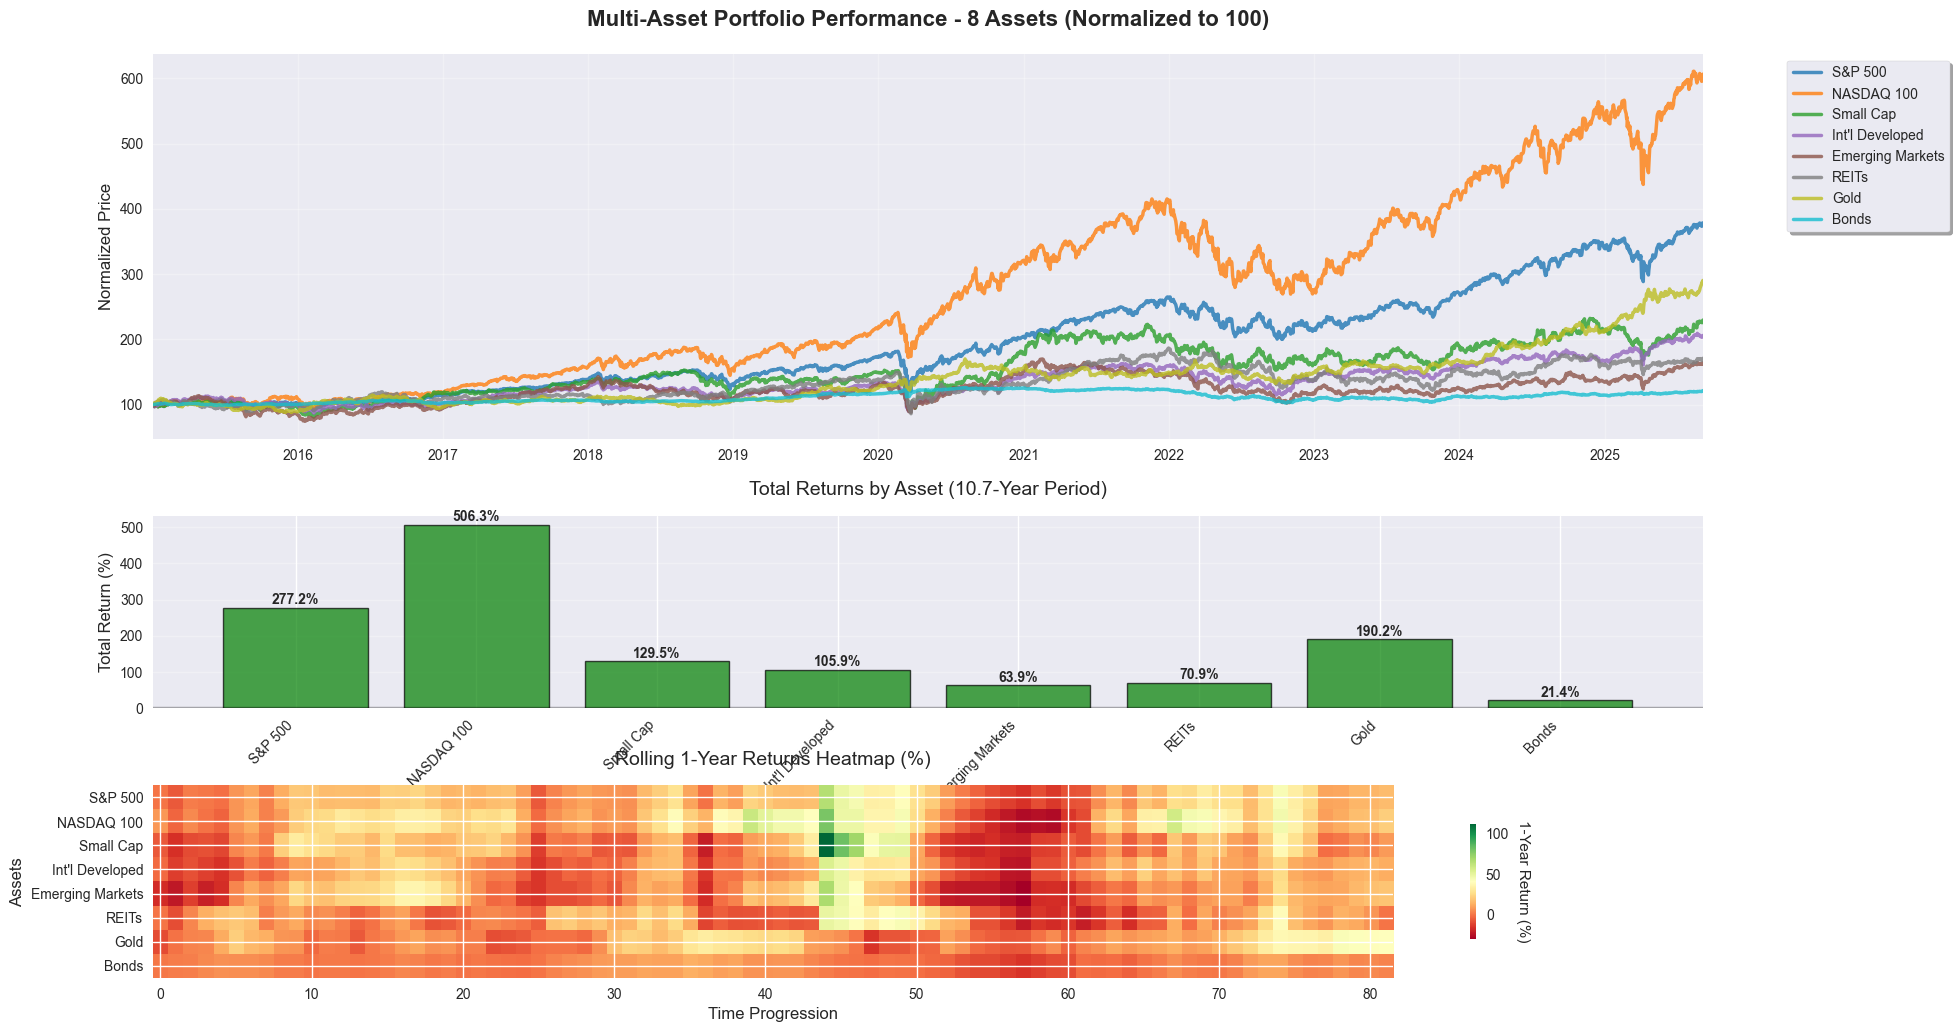


📈 Performance Summary (10.7 years):
  S&P 500        : Total  277.2% | Annualized  13.2%
  NASDAQ 100     : Total  506.3% | Annualized  18.4%
  Small Cap      : Total  129.5% | Annualized   8.1%
  Int'l Developed: Total  105.9% | Annualized   7.0%
  Emerging Markets: Total   63.9% | Annualized   4.7%
  REITs          : Total   70.9% | Annualized   5.1%
  Gold           : Total  190.2% | Annualized  10.5%
  Bonds          : Total   21.4% | Annualized   1.8%


In [8]:
# Create comprehensive performance visualization
fig = plt.figure(figsize=(20, 12))

# Create grid layout
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)

# 1. Normalized Performance Chart
ax1 = fig.add_subplot(gs[0, :])
normalized_prices = pf_data / pf_data.iloc[0] * 100

# Plot each asset with distinct colors and styles
colors = plt.cm.tab10(np.linspace(0, 1, len(assets)))
for i, asset in enumerate(pf_data.columns):
    ax1.plot(normalized_prices.index, normalized_prices[asset], 
             linewidth=2.5, label=asset_names.get(asset, asset), 
             color=colors[i], alpha=0.8)

ax1.set_title(f'Multi-Asset Portfolio Performance - {len(assets)} Assets (Normalized to 100)', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Normalized Price', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(normalized_prices.index[0], normalized_prices.index[-1])

# 2. Total Returns Bar Chart
ax2 = fig.add_subplot(gs[1, :])
total_returns = (pf_data.iloc[-1] / pf_data.iloc[0] - 1) * 100

# Create color-coded bars (green for positive, red for negative)
bar_colors = ['green' if x >= 0 else 'red' for x in total_returns.values]
bars = ax2.bar(range(len(total_returns)), total_returns.values, 
               color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1)

ax2.set_title(f'Total Returns by Asset ({total_years:.1f}-Year Period)', fontsize=14, pad=15)
ax2.set_ylabel('Total Return (%)', fontsize=12)
ax2.set_xticks(range(len(total_returns)))
ax2.set_xticklabels([asset_names.get(asset, asset) for asset in total_returns.index], 
                    rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, total_returns.values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, 
             height + (2 if height >= 0 else -4), 
             f'{value:.1f}%', ha='center', 
             va='bottom' if height >= 0 else 'top', 
             fontweight='bold', fontsize=10)

# 3. Rolling 1-Year Returns Heatmap
ax3 = fig.add_subplot(gs[2, :])
rolling_returns = pf_data.pct_change(252).dropna() * 100  # 1-year rolling returns

# Create heatmap data (sample every 30 days for readability)
heatmap_data = rolling_returns.iloc[::30].T
im = ax3.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', interpolation='nearest')

ax3.set_title('Rolling 1-Year Returns Heatmap (%)', fontsize=14, pad=15)
ax3.set_ylabel('Assets', fontsize=12)
ax3.set_xlabel('Time Progression', fontsize=12)
ax3.set_yticks(range(len(heatmap_data.index)))
ax3.set_yticklabels([asset_names.get(asset, asset) for asset in heatmap_data.index])

# Colorbar
cbar = plt.colorbar(im, ax=ax3, shrink=0.6)
cbar.set_label('1-Year Return (%)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📈 Performance Summary ({total_years:.1f} years):")
for asset in pf_data.columns:
    annualized_return = ((pf_data[asset].iloc[-1] / pf_data[asset].iloc[0]) ** (1/total_years) - 1) * 100
    total_return = total_returns[asset]
    print(f"  {asset_names.get(asset, asset):15}: Total {total_return:6.1f}% | Annualized {annualized_return:5.1f}%")


# ---
# 

## 4. Risk-Return Analysis {#risk-return}


### 4.1 Calculate Key Metrics

In [9]:
# Calculate daily log returns (more accurate for portfolio math)
log_returns = np.log(pf_data / pf_data.shift(1)).dropna()

print(f"📊 Returns Data:")
print(f"   Trading days analyzed: {len(log_returns):,}")
print(f"   Date range: {log_returns.index[0].date()} to {log_returns.index[-1].date()}")

# Display recent returns sample
print(f"\n📈 Daily Log Returns (Last 5 Days):")
display(log_returns.tail().round(4))

📊 Returns Data:
   Trading days analyzed: 2,684
   Date range: 2015-01-05 to 2025-09-05

📈 Daily Log Returns (Last 5 Days):


,SPY,QQQ,IWM,EFA,EEM,VNQ,GLD,BND
Date,,,,,,,,
2025-08-29,-0.0060,-0.0116,-0.0045,-0.0059,-0.0048,0.0054,0.0096,-0.0012
2025-09-02,-0.0074,-0.0084,-0.0054,-0.0099,-0.0008,-0.0167,0.0234,-0.0021
2025-09-03,0.0054,0.0078,-0.0010,0.0015,0.0038,0.0006,0.0078,0.0033
2025-09-04,0.0083,0.0090,0.0124,0.0072,-0.0032,0.0075,-0.0044,0.0038
2025-09-05,-0.0029,0.0014,0.0050,0.0045,0.0120,0.0112,0.0133,0.0047


### 4.2 Annualized Risk-Return Metrics

In [11]:
# Calculate annualized metrics
annual_returns = log_returns.mean() * TRADING_DAYS
annual_volatility = log_returns.std() * np.sqrt(TRADING_DAYS)
annual_cov_matrix = log_returns.cov() * TRADING_DAYS

# Risk-adjusted metrics
excess_returns = annual_returns - RISK_FREE_RATE
sharpe_ratios = excess_returns / annual_volatility

# Create comprehensive metrics table
risk_return_metrics = pd.DataFrame({
    'Asset Name': [asset_names.get(asset, asset) for asset in pf_data.columns],
    'Annual Return (%)': (annual_returns * 100).round(2),
    'Annual Volatility (%)': (annual_volatility * 100).round(2),
    'Excess Return (%)': (excess_returns * 100).round(2),
    'Sharpe Ratio': sharpe_ratios.round(3),
    'Return/Risk': (annual_returns / annual_volatility).round(3),
    'Total Return (%)': total_returns.round(1)
}, index=pf_data.columns)

print("=" * 80)
print("📊 COMPREHENSIVE RISK-RETURN ANALYSIS")
print("=" * 80)
print(f"Risk-Free Rate: {RISK_FREE_RATE:.1%} | Analysis Period: {total_years:.1f} years")
print()

display(risk_return_metrics)

# Identify best and worst performers
best_return = risk_return_metrics['Annual Return (%)'].idxmax()
best_sharpe = risk_return_metrics['Sharpe Ratio'].idxmax()
lowest_risk = risk_return_metrics['Annual Volatility (%)'].idxmin()

print(f"\n🏆 Performance Leaders:")
print(f"   📈 Highest Return: {asset_names.get(best_return)} ({risk_return_metrics.loc[best_return, 'Annual Return (%)']}%)")
print(f"   ⚡ Best Sharpe Ratio: {asset_names.get(best_sharpe)} ({risk_return_metrics.loc[best_sharpe, 'Sharpe Ratio']})")
print(f"   🛡️  Lowest Risk: {asset_names.get(lowest_risk)} ({risk_return_metrics.loc[lowest_risk, 'Annual Volatility (%)']}%)")

📊 COMPREHENSIVE RISK-RETURN ANALYSIS
Risk-Free Rate: 4.5% | Analysis Period: 10.7 years



,Asset Name,Annual Return (%),Annual Volatility (%),Excess Return (%),Sharpe Ratio,Return/Risk,Total Return (%)
SPY,S&P 500,12.47,17.99,7.97,0.443,0.693,277.2
QQQ,NASDAQ 100,16.92,22.17,12.42,0.560,0.763,506.3
IWM,Small Cap,7.80,22.73,3.30,0.145,0.343,129.5
EFA,Int'l Developed,6.78,17.46,2.28,0.131,0.388,105.9
EEM,Emerging Markets,4.64,20.66,0.14,0.007,0.224,63.9
VNQ,REITs,5.03,20.89,0.53,0.025,0.241,70.9
GLD,Gold,10.00,14.44,5.50,0.381,0.693,190.2
BND,Bonds,1.82,5.43,-2.68,-0.493,0.335,21.4



🏆 Performance Leaders:
   📈 Highest Return: NASDAQ 100 (16.92%)
   ⚡ Best Sharpe Ratio: NASDAQ 100 (0.56)
   🛡️  Lowest Risk: Bonds (5.43%)


### 4.3 Risk-Return Scatter Plot

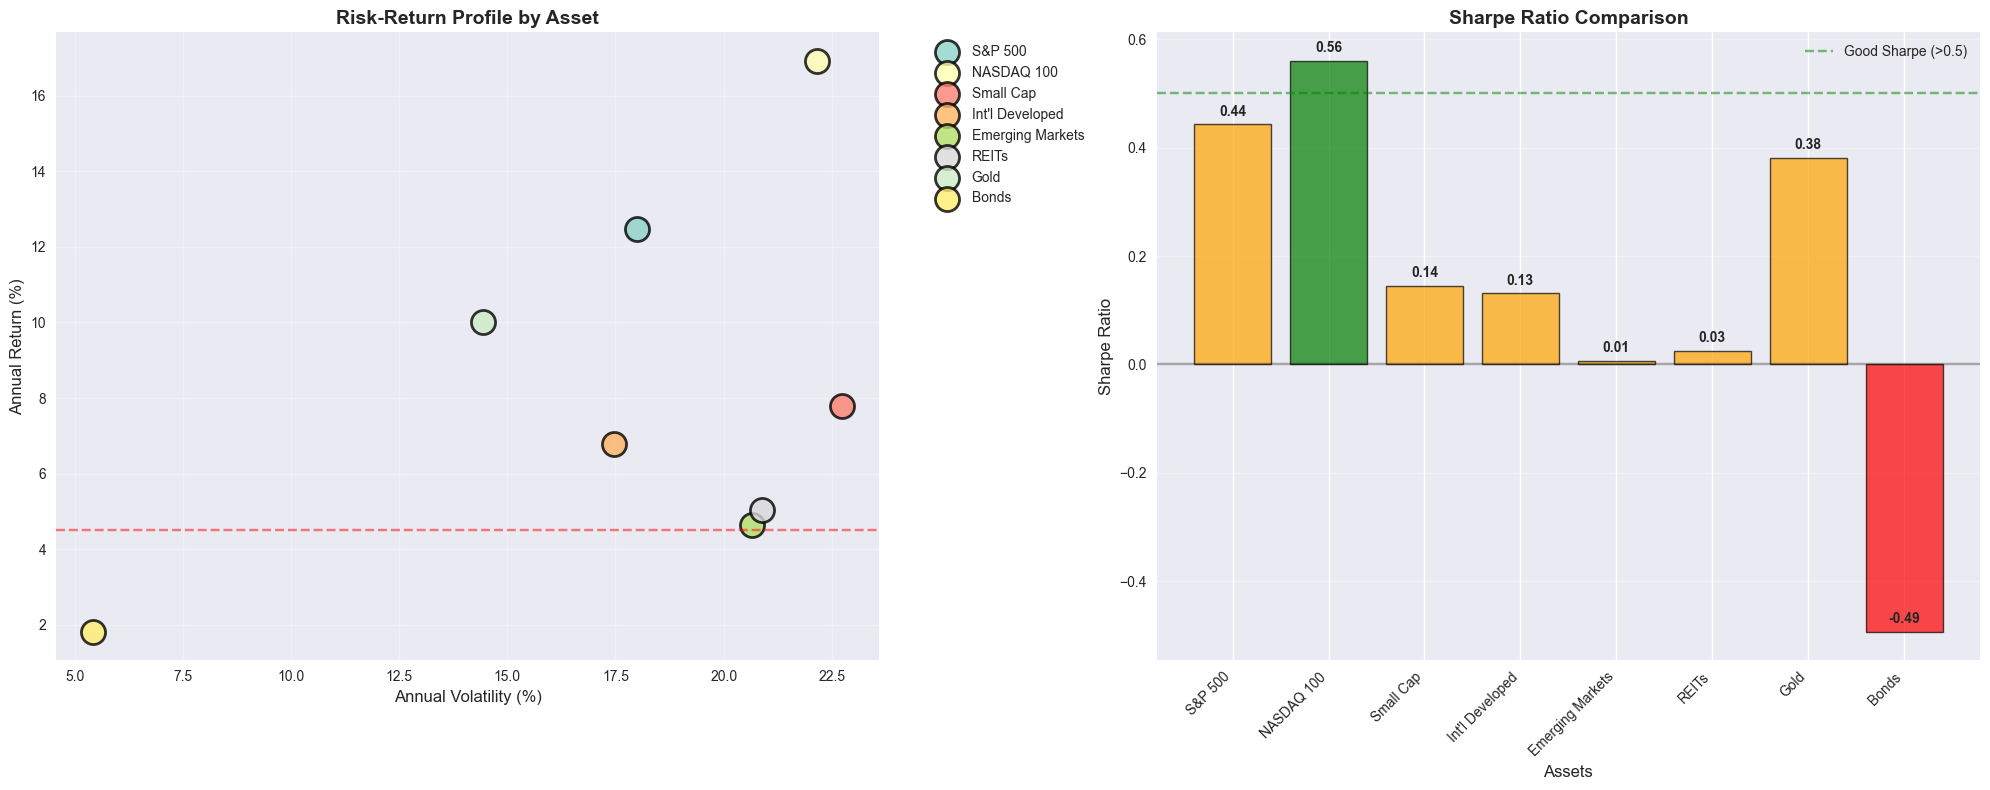

In [12]:
# Create enhanced risk-return scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Risk vs Return
asset_colors = plt.cm.Set3(np.linspace(0, 1, len(assets)))

for i, asset in enumerate(pf_data.columns):
    ax1.scatter(annual_volatility[asset] * 100, annual_returns[asset] * 100, 
               s=300, alpha=0.8, color=asset_colors[i], 
               edgecolors='black', linewidth=2,
               label=asset_names.get(asset, asset))

ax1.set_xlabel('Annual Volatility (%)', fontsize=12)
ax1.set_ylabel('Annual Return (%)', fontsize=12)
ax1.set_title('Risk-Return Profile by Asset', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add risk-free rate line
ax1.axhline(y=RISK_FREE_RATE*100, color='red', linestyle='--', alpha=0.5, 
            label=f'Risk-Free Rate ({RISK_FREE_RATE:.1%})')

# Right plot: Sharpe Ratios
sharpe_values = risk_return_metrics['Sharpe Ratio'].values
asset_labels = [asset_names.get(asset, asset) for asset in risk_return_metrics.index]

# Color bars by Sharpe ratio value
bar_colors = ['green' if x > 0.5 else 'orange' if x > 0 else 'red' for x in sharpe_values]
bars = ax2.bar(range(len(sharpe_values)), sharpe_values, 
               color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1)

ax2.set_xlabel('Assets', fontsize=12)
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(asset_labels)))
ax2.set_xticklabels(asset_labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Good Sharpe (>0.5)')

# Add value labels
for bar, value in zip(bars, sharpe_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

ax2.legend()
plt.tight_layout()
plt.show()

## 5. Drawdown Analysis {#drawdown}

### 5.1 Drawdown Calculation Function

In [14]:
def calculate_comprehensive_drawdown(price_series):
    """
    Calculate comprehensive drawdown metrics for a price series.
    
    Parameters:
    -----------
    price_series : pandas.Series
        Time series of asset prices
    
    Returns:
    --------
    dict : Dictionary containing drawdown metrics
    """
    # Calculate returns and cumulative wealth
    returns = price_series.pct_change().dropna()
    cumulative_wealth = (1 + returns).cumprod()
    
    # Running maximum (peak)
    running_max = cumulative_wealth.expanding().max()
    
    # Drawdown calculation
    drawdown = (cumulative_wealth - running_max) / running_max
    
    # Key metrics
    max_drawdown = drawdown.min()
    current_drawdown = drawdown.iloc[-1]
    
    # Drawdown duration analysis
    drawdown_duration = 0
    current_duration = 0
    max_duration_start = None
    max_duration_end = None
    
    in_drawdown = False
    drawdown_start = None
    
    for i, dd in enumerate(drawdown):
        if dd < -0.001:  # In drawdown (>0.1% down from peak)
            if not in_drawdown:
                drawdown_start = drawdown.index[i]
                in_drawdown = True
                current_duration = 1
            else:
                current_duration += 1
        else:  # Out of drawdown
            if in_drawdown:
                if current_duration > drawdown_duration:
                    drawdown_duration = current_duration
                    max_duration_start = drawdown_start
                    max_duration_end = drawdown.index[i-1]
                in_drawdown = False
                current_duration = 0
    
    # Handle case where we're still in drawdown at end
    if in_drawdown and current_duration > drawdown_duration:
        drawdown_duration = current_duration
        max_duration_start = drawdown_start
        max_duration_end = drawdown.index[-1]
    
    return {
        'drawdown_series': drawdown,
        'max_drawdown': max_drawdown,
        'current_drawdown': current_drawdown,
        'max_duration_days': drawdown_duration,
        'max_duration_start': max_duration_start,
        'max_duration_end': max_duration_end,
        'cumulative_wealth': cumulative_wealth
    }

### 5.2 Comprehensive Drawdown Analysis

In [15]:
print("=" * 60)
print("📉 COMPREHENSIVE DRAWDOWN ANALYSIS")
print("=" * 60)

# Calculate drawdowns for each asset
drawdown_results = {}
drawdown_summary_data = []

for asset in pf_data.columns:
    dd_result = calculate_comprehensive_drawdown(pf_data[asset])
    drawdown_results[asset] = dd_result
    
    drawdown_summary_data.append({
        'Asset': asset_names.get(asset, asset),
        'Max Drawdown (%)': dd_result['max_drawdown'] * 100,
        'Current Drawdown (%)': dd_result['current_drawdown'] * 100,
        'Max Duration (Days)': dd_result['max_duration_days'],
        'Recovery Status': 'Recovered' if abs(dd_result['current_drawdown']) < 0.01 else 'In Drawdown'
    })

# Create summary table
drawdown_summary = pd.DataFrame(drawdown_summary_data)
print("📊 Drawdown Summary:")
display(drawdown_summary.round(2))

# Identify worst drawdowns
worst_drawdown = drawdown_summary.loc[drawdown_summary['Max Drawdown (%)'].idxmin()]
longest_drawdown = drawdown_summary.loc[drawdown_summary['Max Duration (Days)'].idxmax()]

print(f"\n🔍 Key Findings:")
print(f"   📉 Worst Maximum Drawdown: {worst_drawdown['Asset']} ({worst_drawdown['Max Drawdown (%)']:.1f}%)")
print(f"   ⏱️  Longest Drawdown Period: {longest_drawdown['Asset']} ({longest_drawdown['Max Duration (Days)']} days)")

# Count assets still in drawdown
assets_in_drawdown = sum(1 for x in drawdown_summary['Recovery Status'] if x == 'In Drawdown')
print(f"   📊 Assets currently in drawdown: {assets_in_drawdown}/{len(assets)}")

📉 COMPREHENSIVE DRAWDOWN ANALYSIS
📊 Drawdown Summary:


,Asset,Max Drawdown (%),Current Drawdown (%),Max Duration (Days),Recovery Status
0,S&P 500,-33.72,-0.29,487,Recovered
1,NASDAQ 100,-35.12,-0.74,492,Recovered
2,Small Cap,-41.13,-1.13,752,In Drawdown
3,Int'l Developed,-34.19,-1.54,706,In Drawdown
4,Emerging Markets,-39.82,-3.56,1143,In Drawdown
5,REITs,-42.40,-8.44,922,In Drawdown
6,Gold,-22.00,0.00,897,Recovered
7,Bonds,-18.58,-3.63,1276,In Drawdown



🔍 Key Findings:
   📉 Worst Maximum Drawdown: REITs (-42.4%)
   ⏱️  Longest Drawdown Period: Bonds (1276 days)
   📊 Assets currently in drawdown: 5/8


### 5.3 Drawdown Visualization


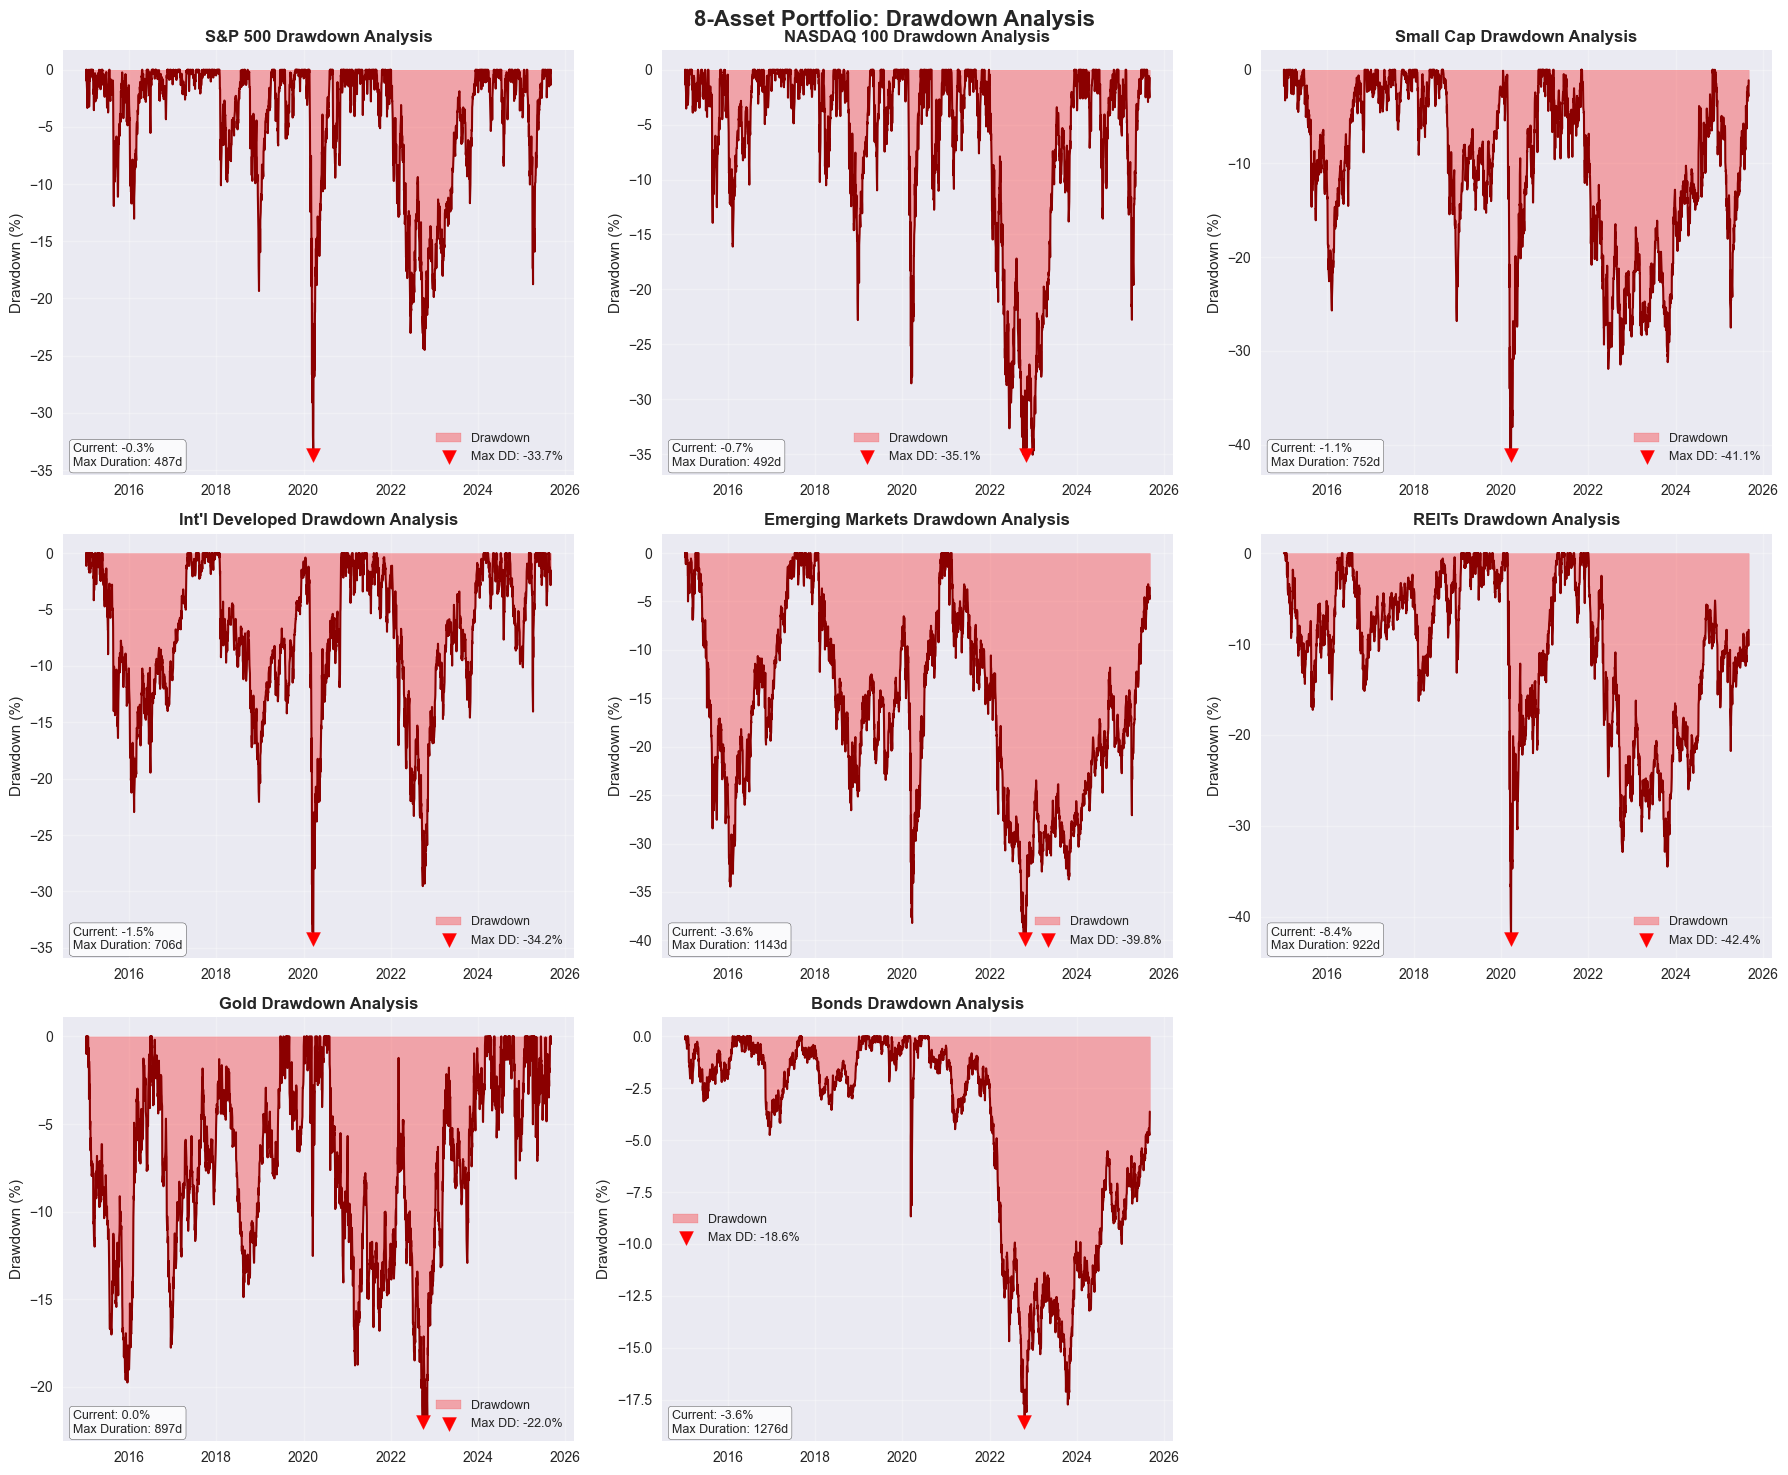

In [16]:
# Create comprehensive drawdown visualization
n_assets = len(pf_data.columns)

# Determine optimal subplot layout
if n_assets <= 4:
    rows, cols = 2, 2
elif n_assets <= 6:
    rows, cols = 2, 3
elif n_assets <= 9:
    rows, cols = 3, 3
else:
    rows, cols = 4, 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 5*rows))
axes = axes.flatten() if n_assets > 1 else [axes]

# Plot drawdowns for each asset
for i, asset in enumerate(pf_data.columns):
    if i < len(axes):
        ax = axes[i]
        dd_data = drawdown_results[asset]
        
        # Plot drawdown
        ax.fill_between(dd_data['drawdown_series'].index, 
                       dd_data['drawdown_series'] * 100, 0, 
                       color='red', alpha=0.3, label='Drawdown')
        ax.plot(dd_data['drawdown_series'].index, 
               dd_data['drawdown_series'] * 100, 
               color='darkred', linewidth=1.5)
        
        # Highlight maximum drawdown point
        max_dd_date = dd_data['drawdown_series'].idxmin()
        max_dd_value = dd_data['max_drawdown'] * 100
        ax.scatter([max_dd_date], [max_dd_value], color='red', s=100, 
                  marker='v', zorder=5, label=f'Max DD: {max_dd_value:.1f}%')
        
        # Formatting
        ax.set_title(f'{asset_names.get(asset, asset)} Drawdown Analysis', 
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('Drawdown (%)')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        
        # Add summary text
        current_dd = dd_data['current_drawdown'] * 100
        duration = dd_data['max_duration_days']
        ax.text(0.02, 0.02, f'Current: {current_dd:.1f}%\nMax Duration: {duration}d', 
               transform=ax.transAxes, fontsize=9, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Hide unused subplots
for i in range(n_assets, len(axes)):
    axes[i].set_visible(False)

plt.suptitle(f'{len(assets)}-Asset Portfolio: Drawdown Analysis', 
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


# ---
# 

## 6. Correlation Analysis {#correlation}

### 6.1 Correlation Matrix Calculation

In [17]:
# Calculate correlation matrix from daily returns
correlation_matrix = log_returns.corr()

print("=" * 60)
print("🔗 CORRELATION ANALYSIS")
print("=" * 60)

# Basic correlation statistics
corr_values = correlation_matrix.values
np.fill_diagonal(corr_values, np.nan)  # Exclude self-correlations

avg_correlation = np.nanmean(corr_values)
max_correlation = np.nanmax(corr_values)
min_correlation = np.nanmin(corr_values)

print(f"📊 Correlation Statistics:")
print(f"   Average correlation: {avg_correlation:.3f}")
print(f"   Highest correlation: {max_correlation:.3f}")
print(f"   Lowest correlation: {min_correlation:.3f}")

# Find specific highest and lowest correlations
max_idx = np.unravel_index(np.nanargmax(corr_values), corr_values.shape)
min_idx = np.unravel_index(np.nanargmin(corr_values), corr_values.shape)

max_pair = (correlation_matrix.index[max_idx[0]], correlation_matrix.columns[max_idx[1]])
min_pair = (correlation_matrix.index[min_idx[0]], correlation_matrix.columns[min_idx[1]])

print(f"\n🔗 Key Relationships:")
print(f"   Highest: {asset_names.get(max_pair[0])} ↔ {asset_names.get(max_pair[1])}: {max_correlation:.3f}")
print(f"   Lowest: {asset_names.get(min_pair[0])} ↔ {asset_names.get(min_pair[1])}: {min_correlation:.3f}")


🔗 CORRELATION ANALYSIS
📊 Correlation Statistics:
   Average correlation: 0.465
   Highest correlation: 0.934
   Lowest correlation: 0.039

🔗 Key Relationships:
   Highest: S&P 500 ↔ NASDAQ 100: 0.934
   Lowest: Small Cap ↔ Gold: 0.039


### 6.2 Advanced Correlation Visualization

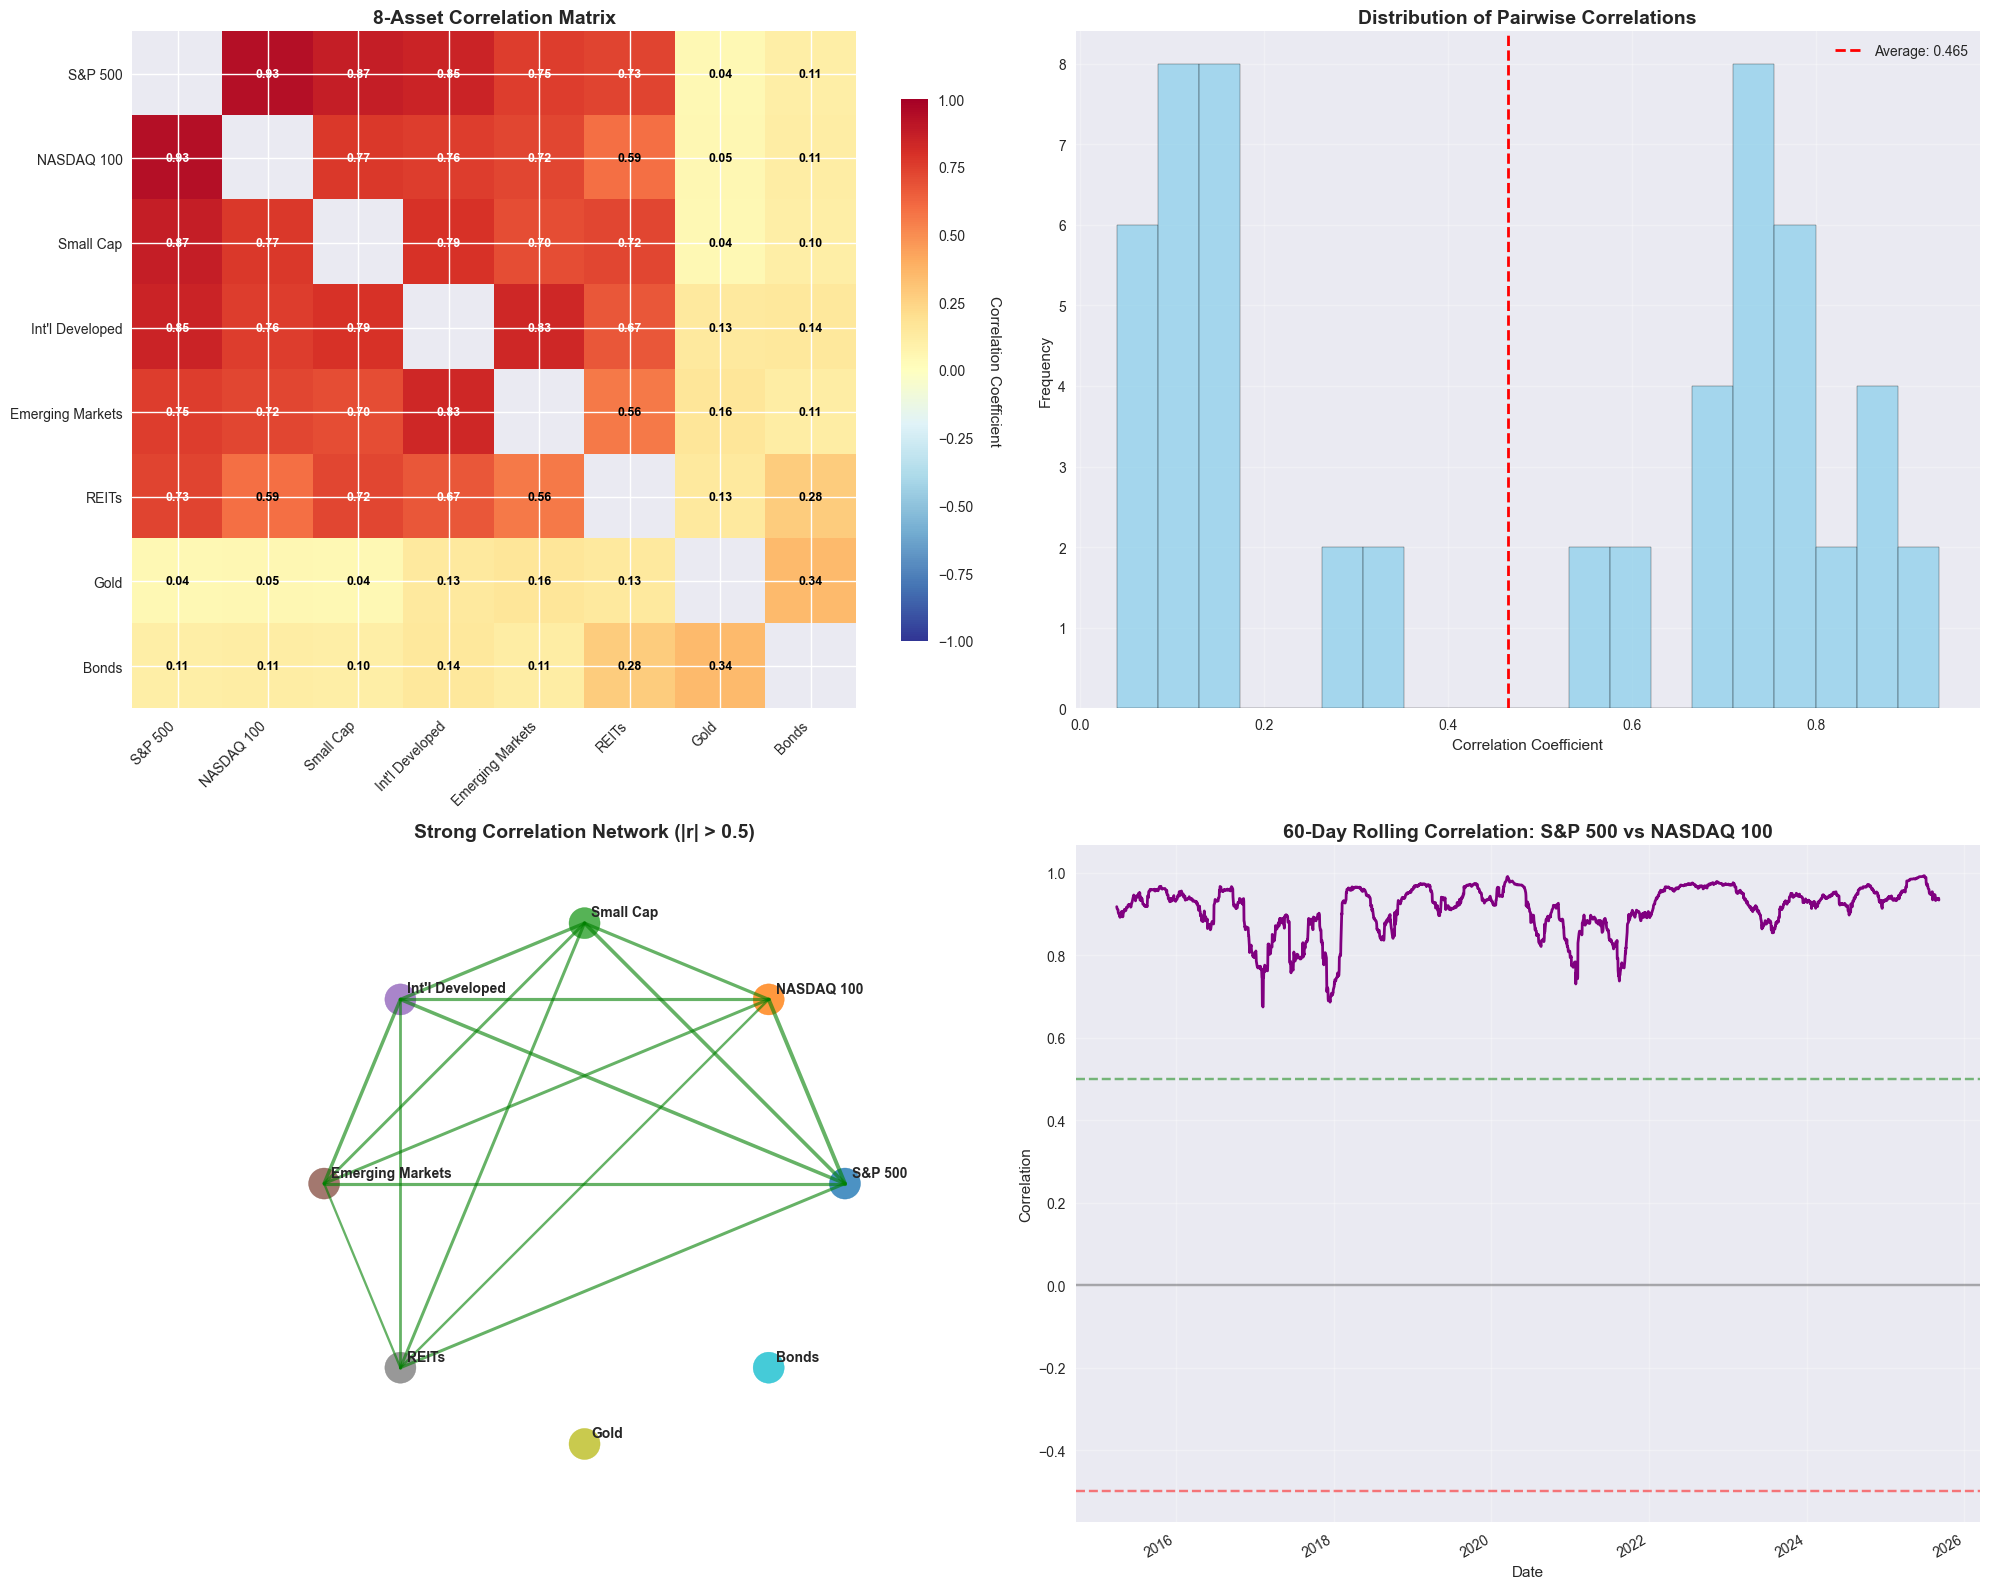


🎯 Diversification Assessment:
   Quality: Good (avg correlation: 0.465)
   Interpretation: Strong diversification benefits expected


In [18]:
# Create comprehensive correlation analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Correlation Heatmap
asset_labels = [asset_names.get(asset, asset) for asset in correlation_matrix.columns]
im1 = ax1.imshow(correlation_matrix, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Correlation Coefficient', rotation=270, labelpad=20)

ax1.set_xticks(range(len(asset_labels)))
ax1.set_yticks(range(len(asset_labels)))
ax1.set_xticklabels(asset_labels, rotation=45, ha='right')
ax1.set_yticklabels(asset_labels)
ax1.set_title(f'{len(assets)}-Asset Correlation Matrix', fontsize=14, fontweight='bold')

# Add correlation values to cells
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        value = correlation_matrix.iloc[i, j]
        if i != j:  # Skip diagonal
            text_color = 'white' if abs(value) > 0.6 else 'black'
            ax1.text(j, i, f'{value:.2f}', ha='center', va='center', 
                    color=text_color, fontweight='bold', fontsize=9)

# 2. Correlation Distribution
corr_flat = corr_values[~np.isnan(corr_values)]
ax2.hist(corr_flat, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(avg_correlation, color='red', linestyle='--', linewidth=2, 
           label=f'Average: {avg_correlation:.3f}')
ax2.set_xlabel('Correlation Coefficient')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Pairwise Correlations', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Correlation Network (simplified)
# Show only strong correlations (>0.5 or <-0.3)
strong_corrs = []
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            strong_corrs.append((i, j, corr_val))

# Create network visualization
import numpy as np
theta = np.linspace(0, 2*np.pi, len(assets), endpoint=False)
radius = 1
x_pos = radius * np.cos(theta)
y_pos = radius * np.sin(theta)

ax3.scatter(x_pos, y_pos, s=500, c=range(len(assets)), cmap='tab10', alpha=0.8)

# Add asset labels
for i, (x, y, asset) in enumerate(zip(x_pos, y_pos, assets)):
    ax3.annotate(asset_names.get(asset, asset), (x, y), xytext=(5, 5), 
                textcoords='offset points', fontsize=10, fontweight='bold')

# Draw correlation lines
for i, j, corr in strong_corrs:
    line_color = 'green' if corr > 0 else 'red'
    line_width = abs(corr) * 3
    ax3.plot([x_pos[i], x_pos[j]], [y_pos[i], y_pos[j]], 
            color=line_color, alpha=0.6, linewidth=line_width)

ax3.set_xlim(-1.3, 1.3)
ax3.set_ylim(-1.3, 1.3)
ax3.set_title('Strong Correlation Network (|r| > 0.5)', fontsize=14, fontweight='bold')
ax3.set_aspect('equal')
ax3.axis('off')

# 4. Rolling Correlation (example with two most correlated assets)
if len(strong_corrs) > 0:
    asset1_idx, asset2_idx, _ = strong_corrs[0]
    asset1, asset2 = assets[asset1_idx], assets[asset2_idx]
    
    rolling_corr = log_returns[asset1].rolling(window=60).corr(log_returns[asset2])
    rolling_corr.plot(ax=ax4, linewidth=2, color='purple')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.axhline(y=0.5, color='green', linestyle='--', alpha=0.5)
    ax4.axhline(y=-0.5, color='red', linestyle='--', alpha=0.5)
    ax4.set_title(f'60-Day Rolling Correlation: {asset_names.get(asset1)} vs {asset_names.get(asset2)}', 
                 fontsize=14, fontweight='bold')
    ax4.set_ylabel('Correlation')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No strong correlations\nto display', 
            transform=ax4.transAxes, ha='center', va='center', fontsize=12)
    ax4.set_title('Rolling Correlation Analysis', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Diversification insights
if avg_correlation < 0.3:
    diversification_quality = "Excellent"
    diversification_color = "green"
elif avg_correlation < 0.6:
    diversification_quality = "Good"
    diversification_color = "orange"
else:
    diversification_quality = "Limited"
    diversification_color = "red"

print(f"\n🎯 Diversification Assessment:")
print(f"   Quality: {diversification_quality} (avg correlation: {avg_correlation:.3f})")
print(f"   Interpretation: {'Strong diversification benefits expected' if avg_correlation < 0.5 else 'Some concentration risk present'}")

## 7. Monte Carlo Simulation {#monte-carlo}

### 7.1 Monte Carlo Portfolio Simulation

In [19]:
print("=" * 70)
print("🎲 MONTE CARLO PORTFOLIO SIMULATION")
print("=" * 70)

# Simulation parameters
num_simulations = 25000  # Increased for better coverage
num_assets = len(pf_data.columns)

print(f"🔧 Simulation Setup:")
print(f"   Number of simulations: {num_simulations:,}")
print(f"   Assets in universe: {num_assets}")
print(f"   Risk-free rate: {RISK_FREE_RATE:.1%}")
print(f"   Expected return range: {annual_returns.min():.1%} to {annual_returns.max():.1%}")
print(f"   Volatility range: {annual_volatility.min():.1%} to {annual_volatility.max():.1%}")

# Initialize storage arrays
portfolio_returns = np.zeros(num_simulations)
portfolio_volatilities = np.zeros(num_simulations)
portfolio_sharpe_ratios = np.zeros(num_simulations)
portfolio_weights = np.zeros((num_simulations, num_assets))

print(f"\n🔄 Running simulation...")
print("Progress: ", end="")

# Progress tracking
progress_points = [int(num_simulations * p) for p in [0.2, 0.4, 0.6, 0.8, 1.0]]
progress_labels = ["20%", "40%", "60%", "80%", "100%"]

# Monte Carlo simulation loop
for i in range(num_simulations):
    # Show progress
    if i in progress_points:
        idx = progress_points.index(i)
        print(f"{progress_labels[idx]} ", end="")
    
    # Generate random weights (Dirichlet distribution for more realistic portfolios)
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    # Calculate portfolio metrics
    portfolio_return = np.sum(weights * annual_returns)
    portfolio_variance = np.dot(weights.T, np.dot(annual_cov_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    
    # Calculate Sharpe ratio
    if portfolio_volatility > 0:
        portfolio_sharpe = (portfolio_return - RISK_FREE_RATE) / portfolio_volatility
    else:
        portfolio_sharpe = 0
    
    # Store results
    portfolio_returns[i] = portfolio_return
    portfolio_volatilities[i] = portfolio_volatility
    portfolio_sharpe_ratios[i] = portfolio_sharpe
    portfolio_weights[i, :] = weights

print("✅")

# Create results DataFrame
simulation_results = pd.DataFrame({
    'Return': portfolio_returns,
    'Volatility': portfolio_volatilities,
    'Sharpe_Ratio': portfolio_sharpe_ratios,
    'Excess_Return': portfolio_returns - RISK_FREE_RATE
})

print(f"\n📊 Simulation Results Summary:")
print(f"   Portfolio return range: {portfolio_returns.min():.2%} to {portfolio_returns.max():.2%}")
print(f"   Portfolio volatility range: {portfolio_volatilities.min():.2%} to {portfolio_volatilities.max():.2%}")
print(f"   Sharpe ratio range: {portfolio_sharpe_ratios.min():.3f} to {portfolio_sharpe_ratios.max():.3f}")

display(simulation_results.describe().round(4))

🎲 MONTE CARLO PORTFOLIO SIMULATION
🔧 Simulation Setup:
   Number of simulations: 25,000
   Assets in universe: 8
   Risk-free rate: 4.5%
   Expected return range: 1.8% to 16.9%
   Volatility range: 5.4% to 22.7%

🔄 Running simulation...
Progress: 20% 40% 60% 80% ✅

📊 Simulation Results Summary:
   Portfolio return range: 4.58% to 12.26%
   Portfolio volatility range: 8.19% to 19.13%
   Sharpe ratio range: 0.006 to 0.557


,Return,Volatility,Sharpe_Ratio,Excess_Return
count,25000.0000,25000.0000,25000.0000,25000.0000
mean,0.0818,0.1415,0.2601,0.0368
std,0.0097,0.0146,0.0640,0.0097
min,0.0458,0.0819,0.0060,0.0008
25%,0.0751,0.1315,0.2176,0.0301
50%,0.0818,0.1411,0.2611,0.0368
75%,0.0883,0.1511,0.3020,0.0433
max,0.1226,0.1913,0.5568,0.0776


### 7.2 Identify Optimal Portfolios

In [21]:
# Find optimal portfolios
optimal_indices = {
    'Max Sharpe': simulation_results['Sharpe_Ratio'].idxmax(),
    'Min Volatility': simulation_results['Volatility'].idxmin(),
    'Max Return': simulation_results['Return'].idxmax()
}

# Create detailed analysis of optimal portfolios
optimal_portfolios = {}

print("=" * 70)
print("🏆 OPTIMAL PORTFOLIO IDENTIFICATION")
print("=" * 70)

for strategy, idx in optimal_indices.items():
    metrics = simulation_results.loc[idx]
    weights = portfolio_weights[idx]
    
    # Store for later use
    optimal_portfolios[strategy] = {
        'metrics': metrics,
        'weights': weights,
        'index': idx
    }
    
    print(f"\n🎯 {strategy} Portfolio:")
    print(f"   Expected Return: {metrics['Return']:.2%}")
    print(f"   Volatility: {metrics['Volatility']:.2%}")
    print(f"   Sharpe Ratio: {metrics['Sharpe_Ratio']:.3f}")
    print(f"   Excess Return: {metrics['Excess_Return']:.2%}")
    
    print(f"   📊 Asset Allocation:")
    for i, asset in enumerate(pf_data.columns):
        weight = weights[i]
        if weight > 0.005:  # Show allocations > 0.5%
            print(f"      {asset_names.get(asset, asset):15}: {weight:6.1%}")
    
    # Calculate expected portfolio characteristics
    expected_annual_return = metrics['Return']
    expected_annual_vol = metrics['Volatility']
    
    print(f"   📈 Risk Metrics:")
    print(f"      Value at Risk (5%): {-1.645 * expected_annual_vol:.2%}")
    print(f"      Max theoretical loss: {-2.5 * expected_annual_vol:.2%}")

# Portfolio comparison
print(f"\n📊 Portfolio Comparison:")
comparison_data = []
for strategy, portfolio in optimal_portfolios.items():
    comparison_data.append({
        'Strategy': strategy,
        'Return': f"{portfolio['metrics']['Return']:.2%}",
        'Volatility': f"{portfolio['metrics']['Volatility']:.2%}",
        'Sharpe': f"{portfolio['metrics']['Sharpe_Ratio']:.3f}",
        'Top Holdings': ', '.join([f"{asset_names.get(pf_data.columns[i], pf_data.columns[i])}"
                                  for i in np.argsort(portfolio['weights'])[-3:][::-1]])
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

🏆 OPTIMAL PORTFOLIO IDENTIFICATION

🎯 Max Sharpe Portfolio:
   Expected Return: 12.26%
   Volatility: 13.95%
   Sharpe Ratio: 0.557
   Excess Return: 7.76%
   📊 Asset Allocation:
      S&P 500        :  25.9%
      NASDAQ 100     :  34.2%
      Int'l Developed:   1.3%
      Emerging Markets:   4.4%
      REITs          :   0.6%
      Gold           :  28.2%
      Bonds          :   5.3%
   📈 Risk Metrics:
      Value at Risk (5%): -22.94%
      Max theoretical loss: -34.86%

🎯 Min Volatility Portfolio:
   Expected Return: 5.79%
   Volatility: 8.19%
   Sharpe Ratio: 0.158
   Excess Return: 1.29%
   📊 Asset Allocation:
      S&P 500        :   2.1%
      NASDAQ 100     :   5.1%
      Small Cap      :   5.0%
      Int'l Developed:   0.5%
      Emerging Markets:   6.7%
      REITs          :  11.1%
      Gold           :  25.8%
      Bonds          :  43.7%
   📈 Risk Metrics:
      Value at Risk (5%): -13.47%
      Max theoretical loss: -20.47%

🎯 Max Return Portfolio:
   Expected Return: 

,Strategy,Return,Volatility,Sharpe,Top Holdings
0,Max Sharpe,12.26%,13.95%,0.557,"NASDAQ 100, Gold, S&P 500"
1,Min Volatility,5.79%,8.19%,0.158,"Bonds, Gold, REITs"
2,Max Return,12.26%,13.95%,0.557,"NASDAQ 100, Gold, S&P 500"


## 8. Efficient Frontier Visualization {#efficient-frontier}

### 8.1 Enhanced Efficient Frontier Plot

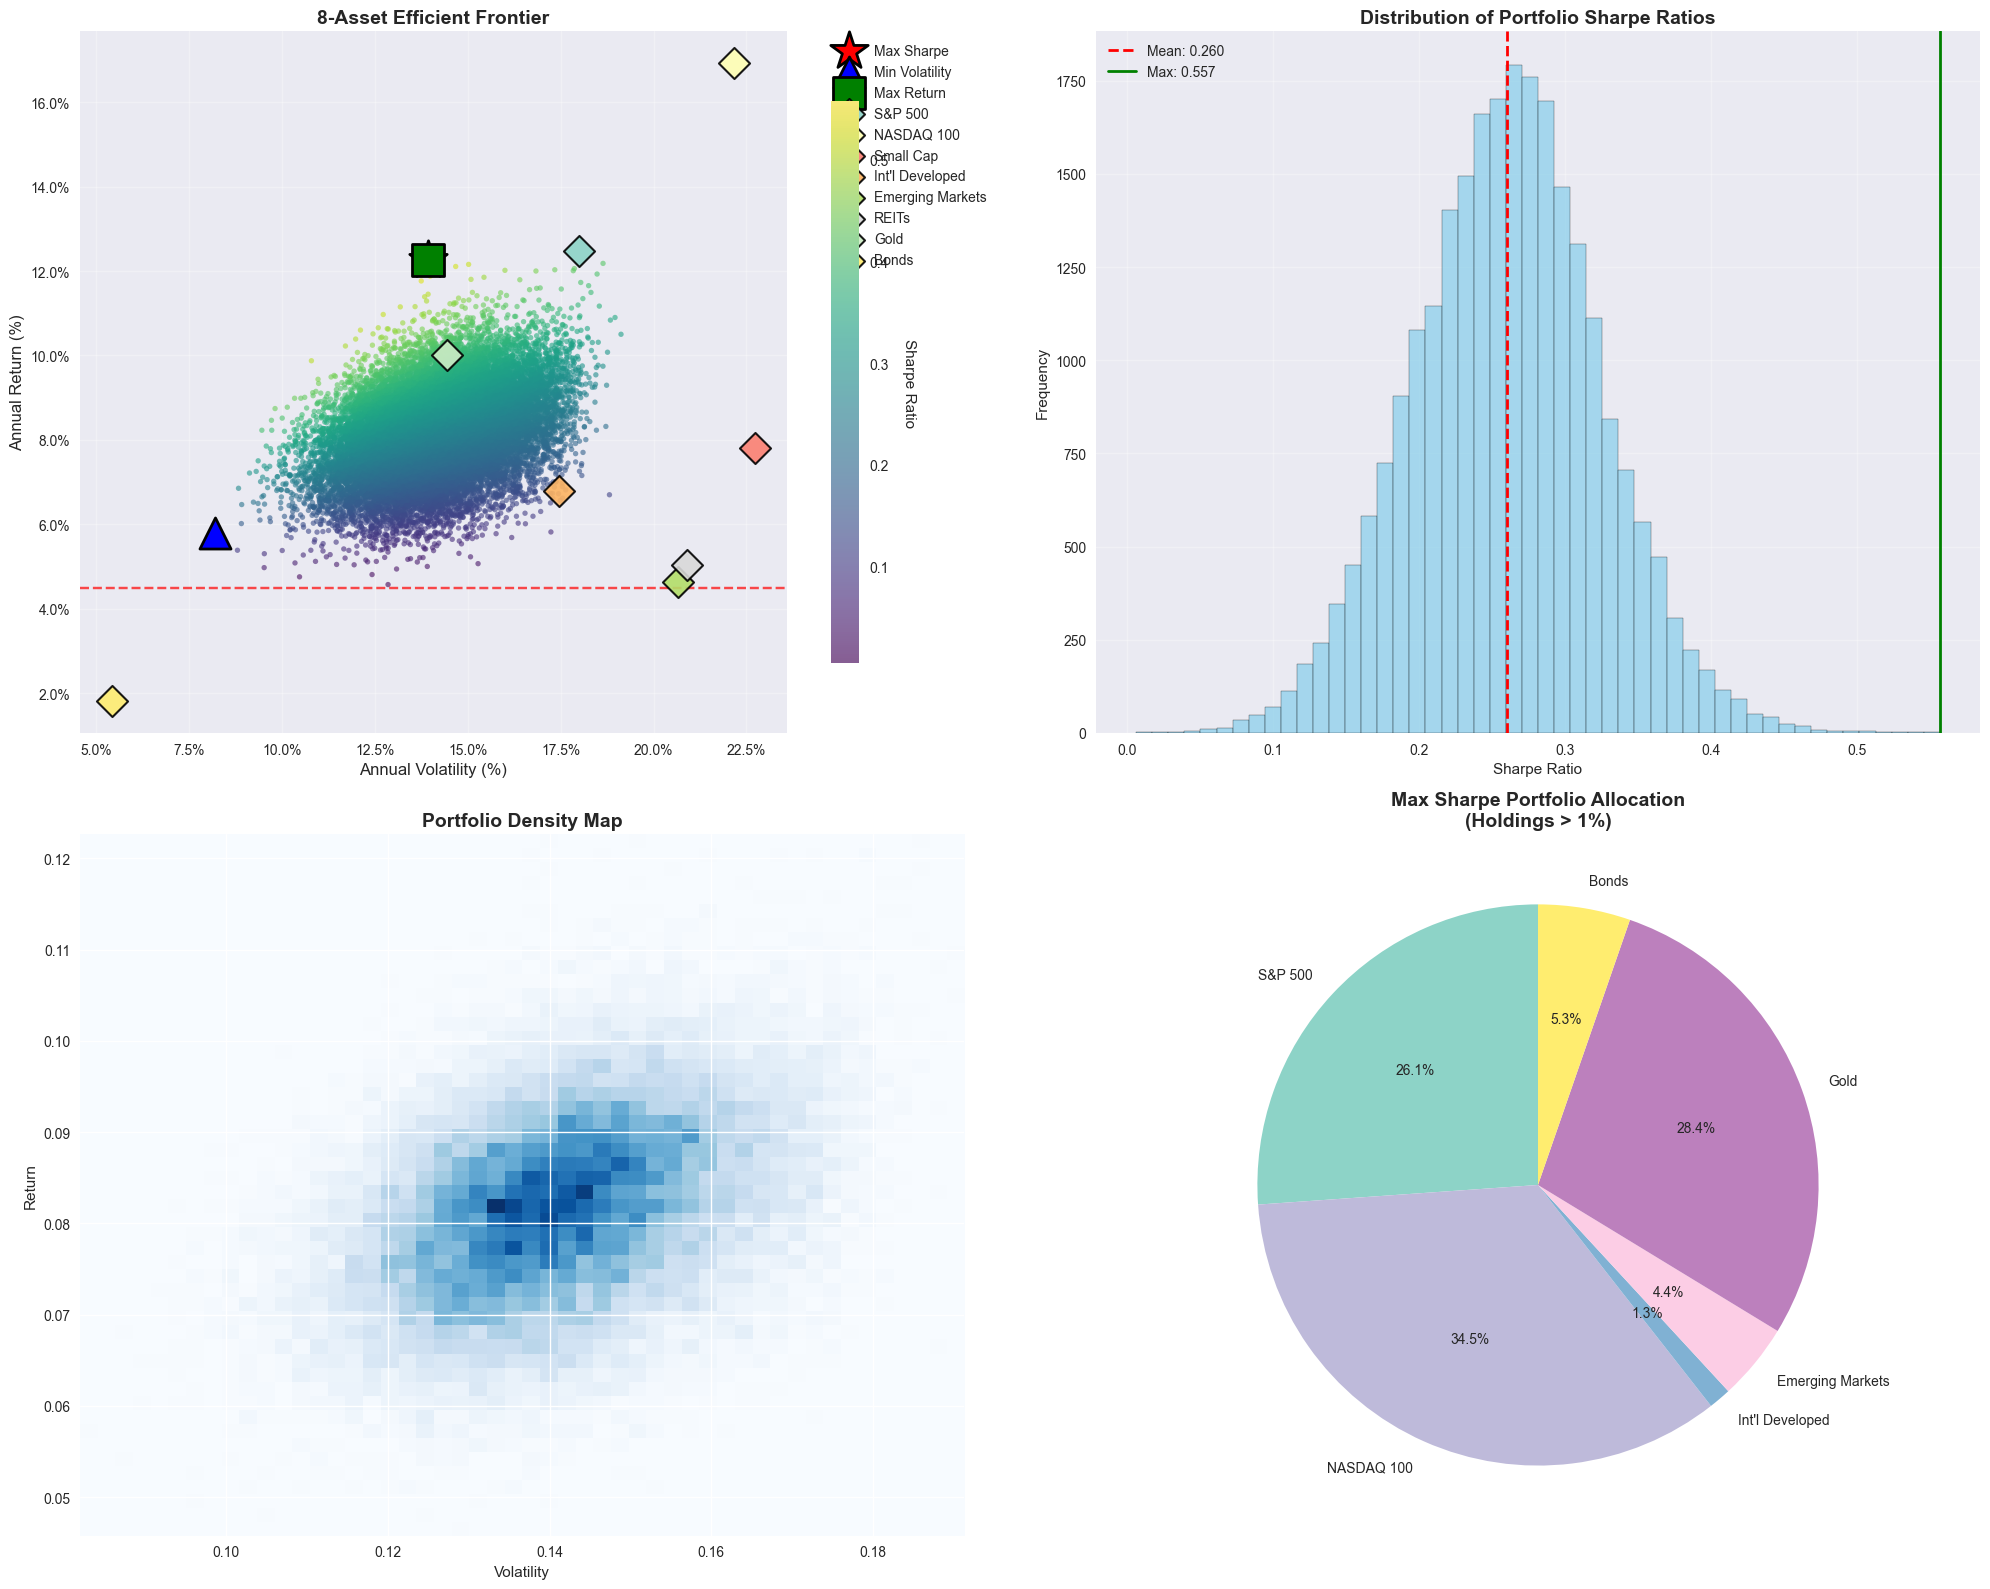

In [24]:
# Create comprehensive efficient frontier visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Main Efficient Frontier
scatter = ax1.scatter(simulation_results['Volatility'], simulation_results['Return'], 
                     c=simulation_results['Sharpe_Ratio'], cmap='viridis', 
                     alpha=0.6, s=15, edgecolors='none')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1, shrink=0.8)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=20)

# Highlight optimal portfolios
colors = ['red', 'blue', 'green']
markers = ['*', '^', 's']
sizes = [800, 500, 500]

for i, (strategy, portfolio) in enumerate(optimal_portfolios.items()):
    metrics = portfolio['metrics']
    ax1.scatter(metrics['Volatility'], metrics['Return'], 
               marker=markers[i], color=colors[i], s=sizes[i], 
               label=f'{strategy}', edgecolors='black', linewidth=2, zorder=10)

# Plot individual assets
asset_colors = plt.cm.Set3(np.linspace(0, 1, len(assets)))
for i, asset in enumerate(pf_data.columns):
    ax1.scatter(annual_volatility[asset], annual_returns[asset], 
               marker='D', s=250, alpha=0.9, color=asset_colors[i],
               label=asset_names.get(asset, asset), 
               edgecolors='black', linewidth=1.5, zorder=5)

ax1.set_xlabel('Annual Volatility (%)', fontsize=12)
ax1.set_ylabel('Annual Return (%)', fontsize=12)
ax1.set_title(f'{len(assets)}-Asset Efficient Frontier', fontsize=14, fontweight='bold')

# FIX: Remove .gca() - ax1 is already an Axes object
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y:.1%}'))

ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add risk-free rate line
ax1.axhline(y=RISK_FREE_RATE, color='red', linestyle='--', alpha=0.7, 
           label=f'Risk-Free Rate ({RISK_FREE_RATE:.1%})')

# 2. Sharpe Ratio Distribution
ax2.hist(simulation_results['Sharpe_Ratio'], bins=50, alpha=0.7, 
         color='skyblue', edgecolor='black')
ax2.axvline(simulation_results['Sharpe_Ratio'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f'Mean: {simulation_results["Sharpe_Ratio"].mean():.3f}')
ax2.axvline(simulation_results['Sharpe_Ratio'].max(), color='green', 
           linestyle='-', linewidth=2, label=f'Max: {simulation_results["Sharpe_Ratio"].max():.3f}')
ax2.set_xlabel('Sharpe Ratio')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Portfolio Sharpe Ratios', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Risk-Return Scatter with Density
hist, xedges, yedges = np.histogram2d(simulation_results['Volatility'], 
                                     simulation_results['Return'], bins=50)
ax3.imshow(hist.T, origin='lower', aspect='auto', cmap='Blues',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_xlabel('Volatility')
ax3.set_ylabel('Return') 
ax3.set_title('Portfolio Density Map', fontsize=14, fontweight='bold')

# 4. Weight Distribution for Max Sharpe Portfolio
max_sharpe_weights = optimal_portfolios['Max Sharpe']['weights']
asset_labels_short = [asset_names.get(asset, asset) for asset in pf_data.columns]

# Create pie chart for significant allocations (>1%)
significant_weights = max_sharpe_weights[max_sharpe_weights > 0.01]
significant_labels = [asset_labels_short[i] for i in range(len(max_sharpe_weights)) 
                     if max_sharpe_weights[i] > 0.01]

if len(significant_weights) > 0:
    wedges, texts, autotexts = ax4.pie(significant_weights, labels=significant_labels, 
                                      autopct='%1.1f%%', startangle=90, 
                                      colors=plt.cm.Set3(np.linspace(0, 1, len(significant_weights))))
    ax4.set_title('Max Sharpe Portfolio Allocation\n(Holdings > 1%)', 
                 fontsize=14, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No significant\nconcentrations', 
            transform=ax4.transAxes, ha='center', va='center')
    ax4.set_title('Max Sharpe Portfolio Allocation', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 8.2 Efficient Frontier Statistics

In [25]:
print("=" * 60)
print("📊 EFFICIENT FRONTIER STATISTICS")
print("=" * 60)

# Calculate frontier statistics
frontier_stats = {
    'Simulated Portfolios': len(simulation_results),
    'Return Range': f"{simulation_results['Return'].min():.2%} to {simulation_results['Return'].max():.2%}",
    'Volatility Range': f"{simulation_results['Volatility'].min():.2%} to {simulation_results['Volatility'].max():.2%}",
    'Sharpe Range': f"{simulation_results['Sharpe_Ratio'].min():.3f} to {simulation_results['Sharpe_Ratio'].max():.3f}",
    'Mean Sharpe': f"{simulation_results['Sharpe_Ratio'].mean():.3f}",
    'Std Sharpe': f"{simulation_results['Sharpe_Ratio'].std():.3f}"
}

print("🎯 Frontier Characteristics:")
for key, value in frontier_stats.items():
    print(f"   {key}: {value}")

# Compare with individual assets
print(f"\n📈 Diversification Benefits:")
best_individual_sharpe = sharpe_ratios.max()
best_portfolio_sharpe = simulation_results['Sharpe_Ratio'].max()
improvement = best_portfolio_sharpe - best_individual_sharpe

print(f"   Best individual asset Sharpe: {best_individual_sharpe:.3f} ({asset_names.get(sharpe_ratios.idxmax())})")
print(f"   Best portfolio Sharpe: {best_portfolio_sharpe:.3f}")
print(f"   Improvement: {improvement:.3f} ({improvement/best_individual_sharpe:.1%})")

if improvement > 0.1:
    print("   🎉 Strong diversification benefit achieved!")
elif improvement > 0:
    print("   ✅ Moderate diversification benefit")
else:
    print("   ⚠️ Limited diversification benefit")

# Risk reduction analysis
min_individual_vol = annual_volatility.min()
min_portfolio_vol = simulation_results['Volatility'].min()
risk_reduction = (min_individual_vol - min_portfolio_vol) / min_individual_vol

print(f"\n🛡️ Risk Reduction Analysis:")
print(f"   Lowest individual asset volatility: {min_individual_vol:.2%} ({asset_names.get(annual_volatility.idxmin())})")
print(f"   Lowest portfolio volatility: {min_portfolio_vol:.2%}")
print(f"   Risk reduction: {risk_reduction:.1%}")


# ---
# 

📊 EFFICIENT FRONTIER STATISTICS
🎯 Frontier Characteristics:
   Simulated Portfolios: 25000
   Return Range: 4.58% to 12.26%
   Volatility Range: 8.19% to 19.13%
   Sharpe Range: 0.006 to 0.557
   Mean Sharpe: 0.260
   Std Sharpe: 0.064

📈 Diversification Benefits:
   Best individual asset Sharpe: 0.560 (NASDAQ 100)
   Best portfolio Sharpe: 0.557
   Improvement: -0.004 (-0.6%)
   ⚠️ Limited diversification benefit

🛡️ Risk Reduction Analysis:
   Lowest individual asset volatility: 5.43% (Bonds)
   Lowest portfolio volatility: 8.19%
   Risk reduction: -50.8%


## 9. Results & Conclusions {#results}

### 9.1 Investment Recommendations

In [26]:
print("=" * 80)
print("🎯 INVESTMENT RECOMMENDATIONS & CONCLUSIONS")
print("=" * 80)

# Determine best strategy based on different investor profiles
investor_profiles = {
    'Conservative': 'Min Volatility',
    'Balanced': 'Max Sharpe', 
    'Aggressive': 'Max Return'
}

print("👥 Recommended Portfolios by Investor Profile:\n")

for profile, strategy in investor_profiles.items():
    portfolio = optimal_portfolios[strategy]
    metrics = portfolio['metrics']
    weights = portfolio['weights']
    
    print(f"🎯 {profile} Investor → {strategy} Portfolio:")
    print(f"   Expected Return: {metrics['Return']:.2%} annually")
    print(f"   Expected Volatility: {metrics['Volatility']:.2%} annually") 
    print(f"   Sharpe Ratio: {metrics['Sharpe_Ratio']:.3f}")
    
    # Top 3 holdings
    top_3_indices = np.argsort(weights)[-3:][::-1]
    print(f"   Top Holdings:")
    for i, idx in enumerate(top_3_indices, 1):
        asset = pf_data.columns[idx]
        weight = weights[idx]
        print(f"      {i}. {asset_names.get(asset, asset)}: {weight:.1%}")
    print()

# Risk warnings and considerations
print("⚠️  Important Considerations:")
print()
print("📊 Model Limitations:")
print("   • Based on historical data - past performance doesn't guarantee future results")
print("   • Assumes normal distribution of returns (may underestimate tail risks)")
print("   • Correlations can change during market stress")
print("   • Transaction costs and taxes not included")
print()

print("🔄 Rebalancing Recommendations:")
print("   • Review portfolio quarterly")
print("   • Rebalance when allocations drift >5% from targets")
print("   • Consider market conditions and transaction costs")
print()

print("📈 Performance Monitoring:")
print("   • Track against benchmarks (60/40 portfolio, target-date funds)")
print("   • Monitor Sharpe ratio and maximum drawdown")
print("   • Adjust risk-free rate assumption as rates change")


🎯 INVESTMENT RECOMMENDATIONS & CONCLUSIONS
👥 Recommended Portfolios by Investor Profile:

🎯 Conservative Investor → Min Volatility Portfolio:
   Expected Return: 5.79% annually
   Expected Volatility: 8.19% annually
   Sharpe Ratio: 0.158
   Top Holdings:
      1. Bonds: 43.7%
      2. Gold: 25.8%
      3. REITs: 11.1%

🎯 Balanced Investor → Max Sharpe Portfolio:
   Expected Return: 12.26% annually
   Expected Volatility: 13.95% annually
   Sharpe Ratio: 0.557
   Top Holdings:
      1. NASDAQ 100: 34.2%
      2. Gold: 28.2%
      3. S&P 500: 25.9%

🎯 Aggressive Investor → Max Return Portfolio:
   Expected Return: 12.26% annually
   Expected Volatility: 13.95% annually
   Sharpe Ratio: 0.557
   Top Holdings:
      1. NASDAQ 100: 34.2%
      2. Gold: 28.2%
      3. S&P 500: 25.9%

⚠️  Important Considerations:

📊 Model Limitations:
   • Based on historical data - past performance doesn't guarantee future results
   • Assumes normal distribution of returns (may underestimate tail risks)
 

### 9.2 Executive Summary Table


In [27]:
print("\n" + "="*80)
print("📋 EXECUTIVE SUMMARY")
print("="*80)

# Create comprehensive summary
summary_data = {
    'Metric': [
        'Analysis Period',
        'Assets Analyzed', 
        'Total Simulations',
        'Best Sharpe Ratio',
        'Lowest Risk Portfolio',
        'Highest Return Portfolio',
        'Average Correlation',
        'Diversification Benefit',
        'Risk Reduction Potential',
        'Recommended Strategy'
    ],
    'Value': [
        f"{total_years:.1f} years ({pf_data.index[0].date()} to {pf_data.index[-1].date()})",
        f"{len(assets)} assets ({', '.join([asset_names.get(a, a) for a in assets])})",
        f"{num_simulations:,} portfolios",
        f"{simulation_results['Sharpe_Ratio'].max():.3f} (vs {sharpe_ratios.max():.3f} best individual)",
        f"{simulation_results['Volatility'].min():.2%} annual volatility",
        f"{simulation_results['Return'].max():.2%} annual return",
        f"{avg_correlation:.3f} ({'Good diversification' if avg_correlation < 0.6 else 'Limited diversification'})",
        f"{(best_portfolio_sharpe - best_individual_sharpe):.3f} Sharpe improvement",
        f"{risk_reduction:.1%} volatility reduction vs single assets",
        "Max Sharpe for balanced investors"
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

print(f"\n🎉 Analysis Complete!")
print(f"✅ Successfully analyzed {len(assets)}-asset portfolio")
print(f"✅ Generated {num_simulations:,} Monte Carlo simulations") 
print(f"✅ Identified optimal portfolios for different risk profiles")
print(f"✅ Quantified diversification benefits")

print(f"\n📊 Key Takeaways:")
if improvement > 0.1:
    print("   🎯 Strong diversification benefits justify multi-asset approach")
elif improvement > 0:
    print("   🎯 Moderate diversification benefits support portfolio approach")
else:
    print("   🎯 Consider concentrated positions in top-performing assets")

if avg_correlation < 0.5:
    print("   🔗 Low correlations provide excellent diversification")
else:
    print("   🔗 Higher correlations limit diversification - consider alternatives")

if risk_reduction > 0.1:
    print("   🛡️ Significant risk reduction achievable through diversification")
else:
    print("   🛡️ Limited risk reduction - individual asset selection may be key")

print("\n" + "="*80)


📋 EXECUTIVE SUMMARY


,Metric,Value
0,Analysis Period,10.7 years (2015-01-02 to 2025-09-05)
1,Assets Analyzed,"8 assets (S&P 500, NASDAQ 100, Small Cap, Int'..."
2,Total Simulations,"25,000 portfolios"
3,Best Sharpe Ratio,0.557 (vs 0.560 best individual)
4,Lowest Risk Portfolio,8.19% annual volatility
5,Highest Return Portfolio,12.26% annual return
6,Average Correlation,0.465 (Good diversification)
7,Diversification Benefit,-0.004 Sharpe improvement
8,Risk Reduction Potential,-50.8% volatility reduction vs single assets
9,Recommended Strategy,Max Sharpe for balanced investors



🎉 Analysis Complete!
✅ Successfully analyzed 8-asset portfolio
✅ Generated 25,000 Monte Carlo simulations
✅ Identified optimal portfolios for different risk profiles
✅ Quantified diversification benefits

📊 Key Takeaways:
   🎯 Consider concentrated positions in top-performing assets
   🔗 Low correlations provide excellent diversification
   🛡️ Limited risk reduction - individual asset selection may be key



### 9.3 Save Results (Optional)

In [32]:
# Uncomment to save results to files
save_results = False  # Set to True to save files

if save_results:
    print("💾 Saving analysis results...")
    
    # Save main datasets
    simulation_results.to_csv('monte_carlo_results.csv', index=False)
    risk_return_metrics.to_csv('asset_risk_return_metrics.csv')
    correlation_matrix.to_csv('correlation_matrix.csv')
    drawdown_summary.to_csv('drawdown_analysis.csv', index=False)
    
    # Save optimal portfolio weights
    optimal_weights_df = pd.DataFrame({
        strategy: portfolio['weights'] 
        for strategy, portfolio in optimal_portfolios.items()
    }, index=[asset_names.get(asset, asset) for asset in pf_data.columns])
    optimal_weights_df.to_csv('optimal_portfolio_weights.csv')
    
    # Save summary
    summary_df.to_csv('executive_summary.csv', index=False)
    
    print("✅ All results saved to CSV files!")
    print("   📁 Files created:")
    print("      • monte_carlo_results.csv")
    print("      • asset_risk_return_metrics.csv") 
    print("      • correlation_matrix.csv")
    print("      • drawdown_analysis.csv")
    print("      • optimal_portfolio_weights.csv")
    print("      • executive_summary.csv")
else:
    print("💡 Tip: Set save_results = True in the cell above to save analysis to CSV files")

print(f"\n🎊 Portfolio Analysis Complete!")
print("="*50)

💡 Tip: Set save_results = True in the cell above to save analysis to CSV files

🎊 Portfolio Analysis Complete!
